In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpltools import color
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import SALS as LS

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('SALS tutorial started')

INFO:root:SALS tutorial started


# Small Angle Light Scattering (SALS)

```SALS``` class is designed to analyze far-field light scattering experiments in the small-angle configuration, where image pixels map not in different locations of the sample (as in DSH) but in differetn scattering vectors. A typical speckle field in SALS experiment looks like this:

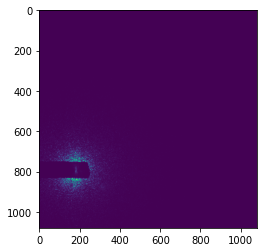

In [2]:
im_shape = (1080, 1080)
froot = r'..\SALS_test'
MI_path = os.path.join(froot, 'MI_SLS.raw')
plt.imshow(MI.ReadBinary(MI_path, im_shape, 'B'))

## 1. Configuration

To initialize a ```SALS``` object:

```python
SALS_analyzer = LS.SALS(MIinput, outFolder, centerPos, ROIs=None, maskRaw=None, BkgCorr=None, expTimes=[1], imgTimes=None, timeAvg_T=None)
```

where:

- ```MIinput``` contains the input images, and can be either a ```MIfile``` or a ```MIstack```
- ```outFolder``` is the output folder path
- ```centerPos``` defines the coordinates of the transmitted beam position (see below)
- ```ROIs``` defines the regions of interest (ROIs) of the analysis (see below)
- ```BkgCorr=[DarkBkg, OptBkg, PDdata]``` contains data for background correction (see below)
- ```expTimes``` is the list of exposure times. With multiple exposure times, ```SALS``` assumes that images in ```MIinput``` cycle through exposure times
- ```imgTimes``` is the list of image times, if images were not acquired at constant FPS (see below)
- ```timeAvg_T``` defines the time averaging window for correlation functions (see below)

In [3]:
MIinput = MI.MIfile(MI_path, os.path.join(froot, 'MI_SLS_metadata.ini'))
print(MIinput)


|---------------|
| MIfile class: |
|---------------+---------------
| Filename      : ..\SALS_test\MI_SLS.raw
| Header        : 0 bytes
| Shape         : [40, 1080, 1080] px
| Pixel format  : B (1 bytes/px)
| Status        : Closed
|---------------+---------------


In [4]:
SLS_ctrPos = [182, 793]
SALS_analyzer = LS.SALS(MIinput, os.path.join(froot, 'out_SLS'), centerPos=SLS_ctrPos)
print(SALS_analyzer)

INFO:root:Set 1 valid ROIs



|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (..\SALS_test\MI_SLS.raw), 40 images
| Output folder   : ..\SALS_test\out_SLS
| Center position : [182, 793]
| ROIs            : 1 (1 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
| DLS lag times   : 0
|-----------------+---------------


### 1.1 ROI definition
The speckle intensity here is not homogeneous as in DSH, but increases moving towards a point, which is the location where the transmitted beam would hit the detector, if there wasn't the black shadow of the beam stop blocking it. The fist step of a SALS analysis, essential to map pixel location in scattering vector (```centerPos```), is to identify the transmitted beam location, and to create a binary mask (```maskRaw```) to exclude from the analysis the pixels shadowed by the beam stop.
By design, ```SALS``` expects that ```centerPos``` is a couple of floats ```(posX, posY)``` specifying the location of the center in pixels, relative to the upper left corner of the image. The upper left corner location is ```(0, 0)```.

Once ```centerPos``` is specified, the analysis can be specialized on annular regions around the center, thereby averaging on scattering vectors of equal magnitude and different azimuthal orientation. 

Azimuthal annuli can be generated using ```GenerateROIs(ROI_specs, imgShape, centerPos, maskRaw)```, where ```ROI_specs=[rSlices, aSlices]```

```SALS_analyzer``` can be configured to work with this set of ROIs by calling

```python
SALS_analyzer.SetROIs(ROI_specs, maskRaw=None)
```

INFO:root:Set 20 valid ROIs


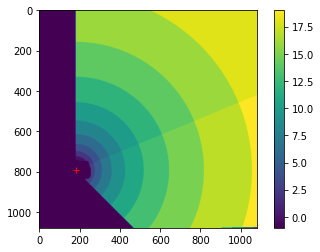

In [5]:
ROI_specs = [np.geomspace(50, 1200, 11), np.linspace(-np.pi/2, np.pi/4, 3)]
px_mask = MI.ReadBinary(os.path.join(froot, 'MI_SLS_pxmask.raw'), im_shape, 'B')

SALS_analyzer.SetROIs(ROI_specs, maskRaw=px_mask)

plt.imshow(SALS_analyzer.ROIs)
plt.plot(*SALS_analyzer.centerPos, 'r+')
plt.colorbar()

ROI coordinates are stored in ```SALS_analyzer.ROIcoords```:

Text(0, 0.5, '$\\theta$ [rad]')

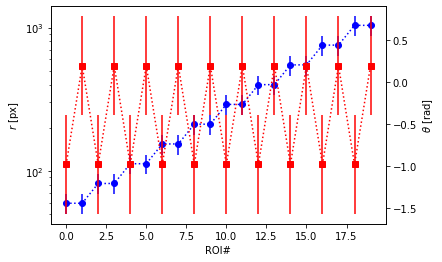

In [6]:
fig, ax = plt.subplots()
ax.errorbar(range(SALS_analyzer.ROIcoords.shape[0]), SALS_analyzer.ROIcoords[:,0], yerr=SALS_analyzer.ROIcoords[:,2]/2, fmt='bo:')
ax2 = ax.twinx()
ax2.errorbar(range(SALS_analyzer.ROIcoords.shape[0]), SALS_analyzer.ROIcoords[:,1], yerr=SALS_analyzer.ROIcoords[:,3]/2, fmt='rs:')
ax.set_yscale('log')
ax.set_ylabel(r'$r$ [px]')
ax.set_xlabel('ROI#')
ax2.set_ylabel(r'$\theta$ [rad]')

### 1.2 Background correction

To extract static structure and form factors from static light scattering (SLS), one needs to measure the background contribution to the scattered intensity, and correct for it. This background contribution can have two sources:

- light scattered by imperfections in the optical apparatus
- intensity detected even with the laser switched off (ambient light, dark counts from the camera)

These contributions can be independently estimated by:

- taking images with the laser switched off (```DarkBkg```)
- taking images with the laser switched on, but with the scattering cell filled with a simple liquid with the same refractive index (```OptBkg```)

```SALS``` can take these measurements together with photodiode measurements (```PDdata```) of both the laser intensity and the transmitted intensity, and use this information to correct for the static background. 

*NOTE (9/2/2021): this functionality is still under development*

### 1.3 Timing

**Exposure times**

Because the dynamic range of a typical 8bit camera is not enough to properly measure typical SLS spectra, where the intensity may vary of several orders of magnitude, the same speckle field is typically recorded using multiple exposure times.
Combining images taken at different exposure time in one unique spectrum requires knowledge of the exposure times (```expTimes```). Exposure times can be set with: 

```python
SALS_analyzer.SetExptimes(expTimes)
```

where ```expTimes``` is a sorted list of exposure times

In [7]:
expTimes = np.loadtxt(os.path.join(froot, 'MI_SLS_exptimes.dat'))
SALS_analyzer.SetExptimes(expTimes)
SALS_analyzer.expTimes

DEBUG:root:Set 40 exptimes, sorted from 0.02 to 10.0


array([ 0.02     ,  0.0234549,  0.0275067,  0.0322584,  0.037831 ,
        0.0443662,  0.0520303,  0.0610184,  0.0715591,  0.0839207,
        0.0984178,  0.115419 ,  0.135357 ,  0.15874  ,  0.186162 ,
        0.218321 ,  0.256035 ,  0.300265 ,  0.352134 ,  0.412965 ,
        0.484303 ,  0.567965 ,  0.666079 ,  0.781142 ,  0.916083 ,
        1.07433  ,  1.25992  ,  1.47757  ,  1.73281  ,  2.03215  ,
        2.3832   ,  2.79489  ,  3.2777   ,  3.84392  ,  4.50794  ,
        5.28667  ,  6.19993  ,  7.27095  ,  8.52699  , 10.       ])

**Lag times**

The essence of DLS analysis is comparing the speckle field recorded at two different times. To do that, a list of time delays () must be specified, in image units (```dlsLags```)

**Image times**

In typical SALS experiments, images are acquired at a constant rate (FPS), specified in the metadata of each MIfile (see tutorial 1). However, there are cases in which custom acquisition schemes may be used to enhance the sensitivity to both the fastest and the slowest dynamics. In these cases, the time at which each image has beed taken (```imgTimes```) needs to be provided 

**Averaging period**

SALS analysis uses time resolved correlation (TRC), which provides well-defined correlation values with no need of averaging in time. However, to improve statistics and produce output more directly comparable to traditional DLS, the correlaction values $c_I(t, \tau)$ provided by TRC can be averaged on given time windows to produce intensity correlationc functions $g_2(\tau)-1$. To this end, the averaging window (```timeAvg_T```) needs to be provided, in image units

### 1.4 Initialization

The above parameters can also be specified in a configuration ```*.ini``` file, in which case the ```SALS``` object can be loaded by calling

```python
SALS_analyzer = LS.LoadFromConfig(ConfigFile, input_sect='input')
```

where:

- ```ConfigFile``` is a string with the full path of the config file to read
- ```input_sect``` is a string with the section of the ini file with the relevant parameters (useful to run serial analysis)

In [8]:
SALS_analyzer = LS.LoadFromConfig('DSH\\config\\serial_SALS_config_testSLS.ini')
print(SALS_analyzer)

INFO:root:Set 10 valid ROIs



|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (C:\Users\steaime\Documents\Codes\DSH\SALS_test\MI_SLS.raw), 40 images
| Output folder   : C:\Users\steaime\Documents\Codes\DSH\SALS_test\out_SLS
| Center position : [182.0, 793.0]
| ROIs            : 10 (10 valid, 0 empty)
| Exposure times  : 40, from 0.02 to 10.0
| DLS lag times   : 0
|-----------------+---------------


## 2. Analysis

### 2.1. ROI average intensity (SLS)

The core of a SALS analysis is to compute ROI-averaged statistics on image intensity $\langle I_p \rangle$ or image correlations $\langle I_p(t) I_p(t+\tau) \rangle$. This can be done by calling:
```python
AvgRes, NormList = SALS_analyzer.ROIaverageIntensity(stack1, ROImasks=None, masks_isBool=False, no_buffer=False, imgs=None):
```

which is a special case of the more general function (with ```stack2==None```):
```python
AvgRes, NormList = SALS_analyzer.ROIaverageProduct(stack1, stack2=None, ROImasks=None, masks_isBool=False, no_buffer=False, imgs=None):
```

where:

- ```stack1``` is a list of indexes. Images will be either read by MIinput or retrieved from img_buffer
- ```stack2``` is None, or list of indexes
         - if None: function will return averages of single images (in stack1)
         - if list: length should be the same as stack1
- ```ROImasks``` : 2D int array or 3D bool array: masks associating each pixel to a ROI
         - if 2D int array: pixel value will denote which ROI the pixel belongs to
         - if 3D bool array: i-th 2D array willbe True for pixels belonging to i-th ROI
         shape of each 2D mask has to match the image shape
         if None, self.ROIs will be used (which is of type int by default)
- ```masks_isBool``` : True or False to indicate that ROImasks is of bool or int type, respectively
- ```no_buffer``` : if True, avoid reading all images to a buffer, but read images one by one
            (dumping them afterwards)
- ```imgs``` : None or 3D array with buffered images. If None, images will be read from MIinput

The function returns:

- ```AvgRes``` : 2D array. Element [i,j] is the average of i-th image on j-th ROI
- ```NormList``` : 1D array. i-th element is the number of pixels in i-th ROI

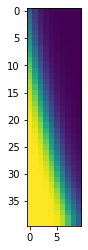

In [9]:
AvgRes, NormList = SALS_analyzer.ROIaverageProduct(list(range(SALS_analyzer.ImageNumber())))
plt.imshow(AvgRes)

Static Light Scattering (SLS) assumes that $\langle I_p \rangle$ is measured at different different exposure times. For each ROI, it looks for the exposure time that has the "best" signal, i.e. for which $I_p$ is large enough to minimize the effect of 8bit discretization, yet small enough to avoid overexposure and saturation. In practice, we set an empyrical criterion based on $\langle I_p \rangle$, which should be as large as possible without exceeding a given threshold value set by ```SALS_analyzer.MaxSafeAvgIntensity```:

In [10]:
SALS_analyzer.MaxSafeAvgIntensity

40

This selection is done by the function
```python
ROIavgs_best, BestExptime_Idx = SALS_analyzer.FindBestExptimes(AverageIntensities)
```

Text(0, 0.5, '$t_{exp}$')

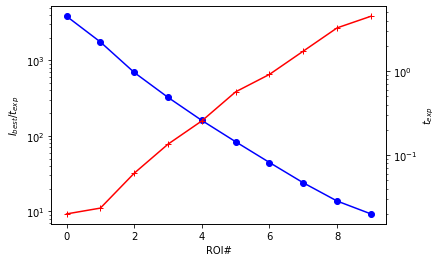

In [11]:
ROIavgs_best, BestExptime_Idx = SALS_analyzer.FindBestExptimes(AvgRes)

fig, ax = plt.subplots()
ax.plot(range(SALS_analyzer.CountROIs()), ROIavgs_best[0], 'bo-')
ax2 = ax.twinx()
ax2.plot(range(SALS_analyzer.CountROIs()), SALS_analyzer.expTimes[BestExptime_Idx[0]], 'r+-')
ax.set_yscale('log')
ax.set_ylabel(r'$I_{best}/t_{exp}$')
ax.set_xlabel('ROI#')
ax2.set_yscale('log')
ax2.set_ylabel(r'$t_{exp}$')

The entire SLS analysis is run by calling
```python
ROIavgs_allExp, ROIavgs_best, BestExptime_Idx, buf_images = SALS_analyzer.doSLS(ROImasks=None, saveFolder=None, buf_images=None, no_buffer=False, force_calc=True)
```

In [13]:
ROIavgs_allExp, ROIavgs_best, BestExptime_Idx, buf_images = SALS_analyzer.doSLS(saveFolder='auto')

DEBUG:root:SLS output saved


### 2.2. ROI average of cross products (DLS)

For DLS we use different analysis parameters:

In [3]:
SALS_analyzer = LS.LoadFromConfig('DSH\\config\\serial_SALS_config_testDLS.ini')
print(SALS_analyzer)

INFO:root:Set 10 valid ROIs



|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (C:\Users\steaime\Documents\Codes\DSH\SALS_test\MI_DLS.raw), 50 images
| Output folder   : C:\Users\steaime\Documents\Codes\DSH\SALS_test\out
| Center position : [499.0, 501.0]
| ROIs            : 10 (10 valid, 0 empty)
| Exposure times  : 1, from 0.03 to 0.03
| DLS lag times   : 7 [0, 1, ..., 16]
|-----------------+---------------


Dynamic light scattering (DLS) measures the two-times correlation of the detected intensity: $c(t, \tau)\propto\langle I_p(t) I_p(t+\tau) \rangle$, where the average $\langle \cdots \rangle$ is computed on pixels belonging to the same ROI. This can be computed using ```SALS_analyzer.ROIaverageProduct``` defined above:

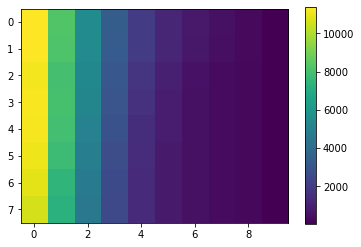

In [12]:
tau_list = [0,1,2,4,8,16,32,49]
AvgRes_num, NormList = SALS_analyzer.ROIaverageProduct([0]*len(tau_list), tau_list)
plt.imshow(AvgRes_num)
plt.colorbar()

### 2.3. Normalization

Each column is a ROI, $\tau$ increases going downwards. The starting point for each column depende on $\langle I_p \rangle$, which is why it is interesting to normalize the correlation function. In principle, this is done using $\langle I_p(t) \rangle\langle I_p(t+\tau) \rangle$

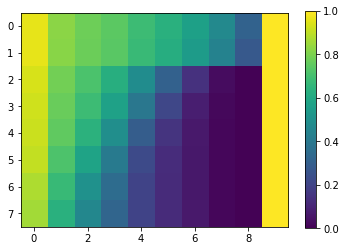

In [13]:
AvgRes_den, NormList = SALS_analyzer.ROIaverageProduct(tau_list)
AvgRes_corr = np.empty_like(AvgRes_num)
for tau_idx in range(AvgRes_num.shape[0]):
    AvgRes_corr[tau_idx] = AvgRes_num[tau_idx]/(AvgRes_den[0]*AvgRes_den[tau_idx]) - 1
plt.imshow(AvgRes_corr, vmin=0, vmax=1)
plt.colorbar()

Normalization using $\langle I_p(t) \rangle\langle I_p(t+\tau) \rangle$ is not perfect, for some reason. For this reason, one can define a normalized correlation as in Duri et al., PRE 2005: $\tilde{c}(t, \tau)=2c(t, \tau)/[c(t, 0)+c(t+\tau, 0)]$.

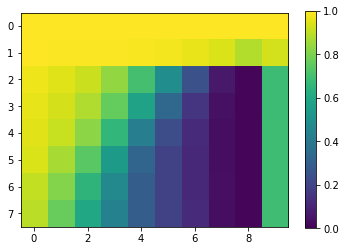

In [14]:
AvgRes_corrNorm = np.empty_like(AvgRes_corr)
for tau_idx in range(AvgRes_num.shape[0]):
    AvgRes_corrNorm[tau_idx] = AvgRes_corr[tau_idx]/AvgRes_corr[0]
plt.imshow(AvgRes_corrNorm, vmin=0, vmax=1)
plt.colorbar()

### 2.4. Correlation timetraces

This whole analysis can be repeated for all available reference times:

In [15]:
%%time
logging.info('Starting with average intensities...')
all_avgs, NormList = SALS_analyzer.ROIaverageProduct(list(range(SALS_analyzer.ImageNumber())))
all_avgs = np.asarray(all_avgs).T
logging.info('Average intensity computed. Now computing cross products...')
all_cIs = np.ones((SALS_analyzer.CountROIs(), SALS_analyzer.ImageNumber(), len(tau_list)), dtype=float)*np.nan
for t in range(SALS_analyzer.ImageNumber()):
    t2_list = [t+tau for tau in tau_list if t+tau < SALS_analyzer.ImageNumber()]
    cur_cIs, NormList = SALS_analyzer.ROIaverageProduct([t]*len(t2_list), t2_list)
    all_cIs[:,t,:len(t2_list)] = np.asarray(cur_cIs).T
logging.info('Cross products completed. Now normalizing result...')
all_cIs_norm = np.empty_like(all_cIs)
for t in range(SALS_analyzer.ImageNumber()):
    for tau_idx in range(len(tau_list)):
        if tau_list[tau_idx] < SALS_analyzer.ImageNumber()-t:
            all_cIs_norm[:,t,tau_idx] = all_cIs[:,t,tau_idx]/(all_avgs[:,t]*all_avgs[:,t+tau_list[tau_idx]]) - 1
all_cIs = all_cIs_norm
all_cIs_norm = np.empty_like(all_cIs)
for t in range(SALS_analyzer.ImageNumber()):
    for tau_idx in range(len(tau_list)):
        if tau_list[tau_idx] < SALS_analyzer.ImageNumber()-t:
            all_cIs_norm[:,t,tau_idx] = 2*all_cIs[:,t,tau_idx]/(all_cIs[:,t,0]+all_cIs[:,t+tau_list[tau_idx],0])
all_cIs = all_cIs_norm
logging.info('...done!')

INFO:root:Starting with average intensities...
INFO:root:Average intensity computed. Now computing cross products...
INFO:root:Cross products completed. Now normalizing result...
INFO:root:...done!


Wall time: 6min 18s


This multi-step analysis can be run through the function:
```python
SALS_analyzer.doDLS(no_buffer=False, force_SLS=True, reftimes='all', lagtimes='auto', save_transposed=False)
```

where:

- ```no_buffer```: If ```True```, avoid reading full MIfile to RAM. It saves memory but slows down processing.
- ```LoadSLS```: If ```False```, program will load previously computed SLS results if available.
- ```reftimes```: ```'auto'```, ```'all'``` or list of ```int```.
    - If ```'auto'``` or ```'all'```, all reference times will be used
    - Otherwise, specialize the analysis to a subset of reference times specified in the list
- ```lagtimes```: ```'auto'```, ```'all'``` or list of ```int```.
    - If ```'auto'``` (default), lagtimes will be set to self.dlsLags
    - If ```'all'```, all available lagtimes will be processed
    - Otherwise, only specified lagtimes will be processed
- ```save_transposed```: specifies the format of correlation timetrace output
    - if ```False```, classic cI output: one line per reference time, one column per time delay
    - if ```True```, transposed output: one line per time delay, one column per 

In [4]:
%%time
SALS_analyzer.doDLS(no_buffer=False, force_SLS=False, reftimes='all', lagtimes='all', save_transposed=True)

INFO:root:SALS Analysis started! Input data is 50 images (50 times, 1 exposure times)
INFO:root:Analysis will resolve 10 ROIs and DLS will be performed on 50 reference times and 51 lagtimes. Output will be saved in folder C:\Users\steaime\Documents\Codes\DSH\SALS_test\out
INFO:root:Now starting with SLS...
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 50 time points, 51 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 50, 1] (50 images)
INFO:root:Computing cI with custom-defined set of reference time and/or lag times: result has shape (10, 50, 51) (10 ROIs, 50 reference times, 51 lag times)
INFO:root:Now saving ROI 0 to file
INFO:root:Now saving ROI 1 to file
INFO:root:Now saving ROI 2 to file
INFO:root:Now saving ROI 3 to file
INFO:root:Now saving ROI 4 to file
INFO:root:Now saving ROI 5 to file
INFO:root:Now saving ROI 6 to file
INFO:root:Now saving ROI 7 to file
INFO:root:Now saving ROI 8 to file
INFO:root:Now saving ROI 9 to f

Wall time: 3min 11s


Results can be visualized as correlation timetraces. Let's define convenience visualization functions:

In [14]:
def PlotContrast(CIlist, times=None, figsize=(10,8), plot_fmt='.-', cmap=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if cmap is not None:
        color.cycle_cmap(len(CIlist), cmap=cmap, ax=ax)
    for i in range(len(CIlist)):
        ax.plot(times, CIlist[i][:,0], plot_fmt, label='ROI{0}'.format(i))
    ax.set_xlabel('t')
    ax.set_ylabel('cI')
    ax.legend(ncol=2)
    return fig, ax

def PlotCIs(CIdata, lags=None, times=None, lag_sel=None, figsize=(10,8), plot_fmt='.-', cmap=None):
    '''
    Plots correlation timetraces
    
    Parameters
    ----------
    - CIdata: 3D array. CIdata[i,j,k] is the correlation of j-th time and k-th time delay for i-th ROI
    - lags: list or 1D array, with all time delays. If None, time delays will be assumed to be 0,1,...,N-1
    - lag_sel: list of indexes of lagtimes to be plotted. If None, all time delays will be plotted
    - cmap: matplotlib color map. For instance: mpl.cm.jet
    '''
    fig, ax = plt.subplots(figsize=figsize)
    if lags is None:
        lags = np.arange(CIdata.shape[1])
    else:
        lags = np.asarray(lags)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if lag_sel is None:
        lag_sel = np.asarray(range(len(lags)), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(lag_sel), cmap=cmap, ax=ax)
    for lidx in lag_sel:
        ax.plot(times, CIdata[:,lidx], plot_fmt, label='d{0}'.format(lags[lidx]))
    ax.set_xlabel('t')
    ax.set_ylabel('cI')
    ax.legend(ncol=2)
    return fig, ax

def PlotCorrFuncs(CorrFuncData, lags, times=None, t_sel=None, figsize=(10,8), plot_fmt='.-', cmap=None, legend=True, 
                  logx=True, logy=False, logG2M1=False, baseline=0, start=1, min_corrval=None, save_file=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if t_sel is None:
        t_sel = np.asarray(range(CorrFuncData.shape[0]), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(t_sel), cmap=cmap, ax=ax)
    if save_file is not None:
        save_data = []
        save_hdr=''
    for tidx in t_sel:
        if start=='first':
            start_val = CorrFuncData[tidx][1]
        else:
            start_val=start
        to_plot = (CorrFuncData[tidx]-baseline)/(start_val-baseline)
        if min_corrval is not None:
            to_plot[to_plot<min_corrval] = np.nan
        if logG2M1:
            to_plot = -np.log(to_plot)
        ax.plot(lags[tidx], to_plot, plot_fmt, label='t{0}'.format(times[tidx]))
        if save_file is not None:
            save_data.append(lags[tidx])
            save_data.append(to_plot)
            if save_hdr!='':
                save_hdr += '\t'
            save_hdr += 't' + str(times[tidx])
            if logG2M1:
                save_hdr += '\t-ln(g2-1)(t={0})'.format(times[tidx])
            else:
                save_hdr += '\tg2-1(t={0})'.format(times[tidx])
    ax.set_xlabel(r'$\tau$')
    if logG2M1:
        ax.set_ylabel(r'$-\ln(g_2-1)$')
    else:
        ax.set_ylabel(r'$g_2-1$')
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    if legend:
        ax.legend(ncol=2)
    if save_file is not None:
        np.savetxt(save_file, np.asarray(save_data).T, delimiter='\t', header=save_hdr)
    return fig, ax

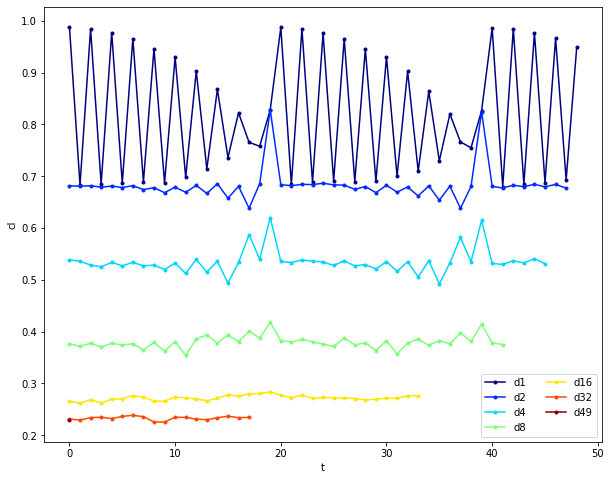

In [20]:
fig, ax = PlotCIs(all_cIs[4], lags=tau_list, lag_sel=list(range(1,len(tau_list))), cmap=mpl.cm.jet)

### 2.4. Timetrace averaging and non-uniform acquisition schemes

If the process was pseudo stationary and images were taken at constant frame rate, one could simply average these correlation traces to get a correlation function. Here, the time interval between two images is not constant, and this time averaging requires knowledge of the time each frame was taken. Image times can be loaded from file using
```python
imgTimes = SALS.LoadImageTimes(img_times_source, root_folder=None, usecols=0, skiprows=1, default_value=None)
```

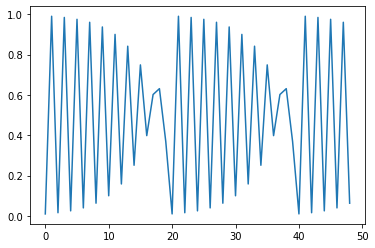

In [17]:
imgTimes = LS.LoadImageTimes('MI_imgTimes.dat', root_folder='..\\SALS_test\\', usecols=3, skiprows=1, default_value=None)
plt.plot(np.diff(imgTimes))

Once correlation data and image times are known, averaging of correlation timetraces can be done by calling
```python
AvgCorr, CorrLags = SALS.AverageCorrTimetrace(CorrData, ImageTimes, Lagtimes_idxlist, average_T=None)
```

where:

- ```CorrData``` is a 2D array. Element [i,j] is $\tilde{c}(t_i, \tau_j)$
- ```ImageTimes``` is 1D array of ```float```. i-th element is the physical time at which i-th image was taken
- ```Lagtimes_idxlist``` is 1D array of ```int```. i-th element is the lagtime, in image units
- ```average_T``` is ```int``` or ```None```. When averaging over time, resolve the average on chunks of ```average_T``` images each.
                 If None, result will be average on the whole stack

This function returns:

- ```g2m1```: 2D array. Element [i,j] represents j-th lag time and i-th time-resolved chunk
- ```g2m1_lags```: 2D array. It contains the time delays, in physical units, of the respective correlation data

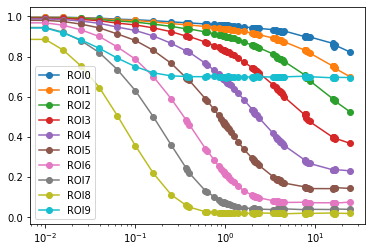

In [18]:
fig, ax = plt.subplots()
for i in range(all_cIs.shape[0]):
    g2m1, g2m1_lags = LS.AverageCorrTimetrace(all_cIs[i], imgTimes, tau_list, average_T=None)
    ax.plot(g2m1_lags[0], g2m1[0], '-o', label='ROI{0}'.format(i))
ax.set_xscale('log')
ax.legend()

### 2.5. Complete data analysis process

All the parameters of the analysis can be stored in the ```SALS_analyzer``` object, and complete analysis can be simply run by calling:
```python
SALS_analyzer.Run(self, no_buffer=False)
```
where ```no_buffer``` is a parameter that dictates whether all images are read into a buffer and then processed (```no_buffer==False```, more time efficient, high memory consumption), or rather read as needed and dumped afterwards (```no_buffer==False```, less time efficient, lower memory consumption)

In [ ]:
SALS_analyzer.Run(doDLS=True, no_buffer=False)

Analysis result is saved in ```SALS_analyzer.outFolder```. 
Several output files will be generated:
- ROI selection
    - **ROIcoords.dat**: polar coordinates of ROIs
    - **ROImask.raw**: raw image (data type: 32bit integer, signed, no header, same shape as original image). Pixel value is the index of the ROI that pixel belongs to (0-based, as in the DLS filenames), and -1 for pixel not belonging to any ROI
- SLS output:
    - **I_r_raw.dat**: ROI-averaged image intensity for each input image (one per exposure time, if multiple exposure times are present). Ageraged intensity is already normalized by the exposure time
    - **exptimes.dat**: optimal exposure time for each ROI and acquired image
    - **I_r.dat**: ROI-averaged optimal image intensity for each input image (obtained selecting the optimal exposure time reported in exptimes.dat)
- DLS output:
    - **cI_ROIxxx_eyy.dat**: correlation timetraces, where xxx is the ROI index and yy the exposure time index
    - **g2m1_ROIxxx_eyy.dat**: time-averaged correlation functions

The last step of DLS analysis (the time averaging of the correlation timetraces) can be repeated after the analysis is completed, using:
```python
SALS_analyzer.AverageG2M1(cI_file, average_T=None)
```

In [12]:
LS.AverageG2M1(os.path.join(SALS_analyzer.outFolder, 'cI_ROI005_e00.dat'), average_T=20)

## 3. Postprocess

### 3.1 Loading SLS results

In [5]:
SLSdata, rarr, phiarr, times = LS.OpenSLS(r'D:\steaime\Data\SALS\210202\out_stack_corr', open_raw=False)

In [55]:
def PlotSLS(SLSdata, rs, times=None, timesel=None, OptBkg=None, figsize=(10,8), plot_fmt='.-', cmap=None, legend=True, funcfit=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(SLSdata.shape[1])
    if timesel is None:
        timesel = np.asarray(range(len(times)), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(timesel), cmap=cmap, ax=ax)
    for tidx in timesel:
        if OptBkg is None:
            to_plot = SLSdata[:,tidx]
        else:
            to_plot = SLSdata[:,tidx] - OptBkg
        ax.plot(rs, to_plot, plot_fmt, label='t{0}'.format(times[tidx]))
    if funcfit is not None:
        for tidx in timesel:
            if OptBkg is None:
                to_fit = SLSdata[:,tidx]
            else:
                to_fit = SLSdata[:,tidx] - OptBkg
            popt, _ = optimize.curve_fit(funcfit, rs, to_fit)
            ax.plot(rs, funcfit(rs, *popt), '--', label='t{0}_fit'.format(times[tidx]))
    ax.set_xlabel('r')
    ax.set_ylabel('I')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if legend:
        ax.legend(ncol=2)
    return fig, ax

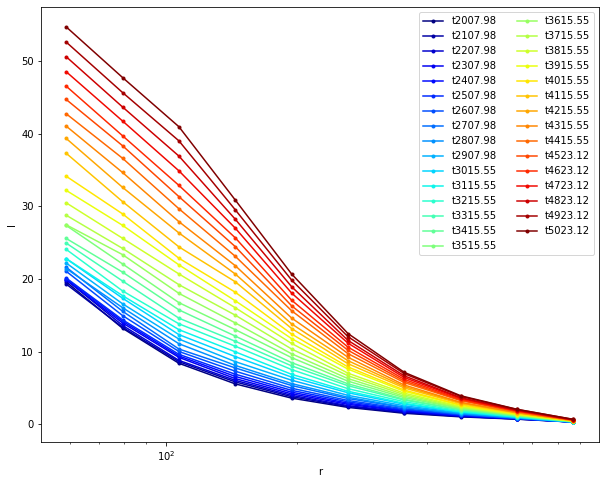

In [69]:
fig, ax = PlotSLS(SLSdata, rarr, times=times, timesel=list(range(400, SLSdata.shape[1]//13, 20)), cmap=mpl.cm.jet)#, OptBkg=SLSdata[:,380]
ax.set_yscale('linear')
#ax.set_ylim([0.1, 40])

### 3.2 Loading DLS results

In [2]:
cIs, times, lags, ROI_list, exptime_list = LS.OpenCIs(r'D:\steaime\Data\220711_Chitosan\HighConc\Sample\out_stack_dls')
times = times[0]
lags = lags[0]

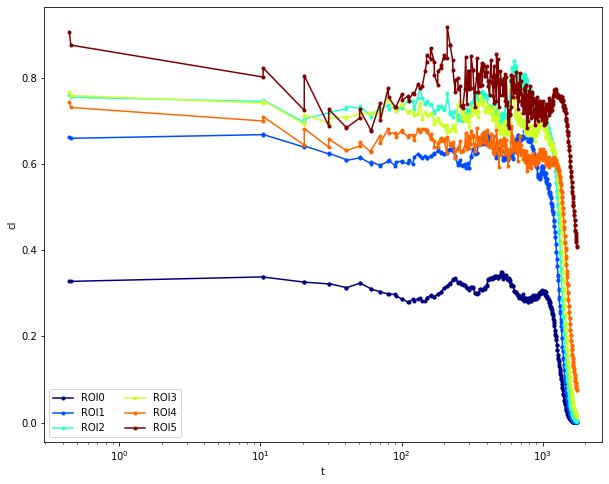

In [5]:
fig, ax = PlotContrast(cIs, times, cmap=mpl.cm.jet)
ax.set_xscale('log')
#ax.set_xlim([100, 100000])

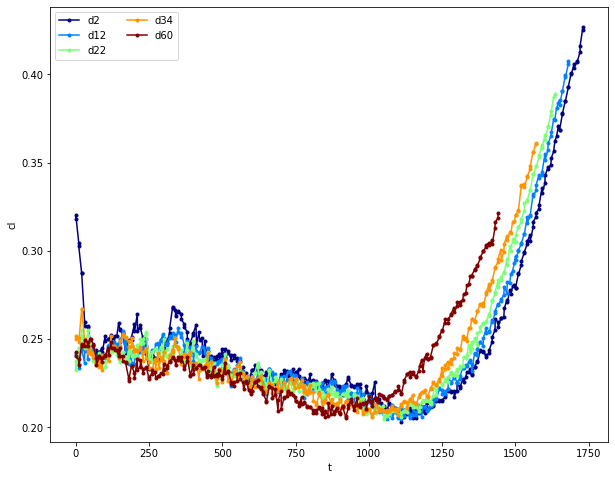

In [8]:
fig, ax = PlotCIs(cIs[5], lags, times, lag_sel=list(range(2, len(lags), 5)), cmap=mpl.cm.jet)

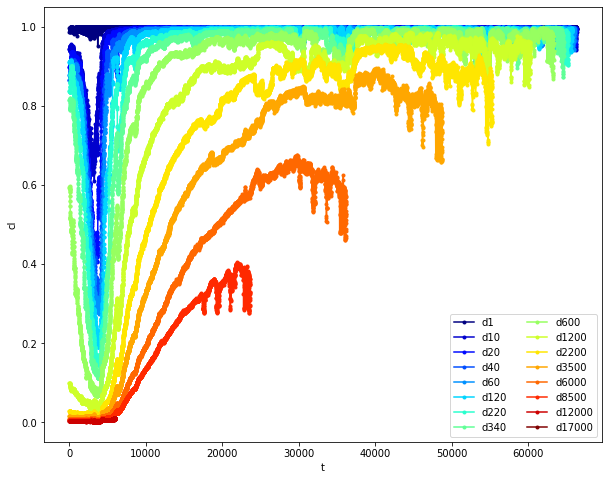

In [36]:
fig, ax = PlotCIs(cIs[2], lags, times, lag_sel=list(range(1, len(lags), 5)), cmap=mpl.cm.jet)

In [5]:
froot = r'D:\steaime\Data\SALS\210202\out_stack_corr'
g2m1s, lags, times, ROI_list, exptime_list = LS.OpenG2M1s(froot)#SALS_analyzer.outFolder)
times = times[0]
lags = lags[0]

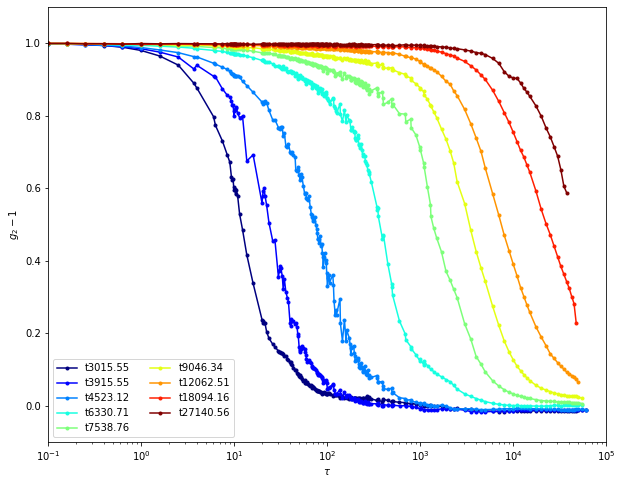

In [24]:
baselines = [0, 0, 0, 0, 0.03, 0.06, 0.07, 0.09, 0, 0]
idx = 7
corr_logy = False
save_file = None if corr_logy else os.path.join(froot, 'g2m1_ROI' + str(idx).zfill(3) + '_corr.dat')
fig, ax= PlotCorrFuncs(g2m1s[idx], lags, times, t_sel=[10, 13, 15, 21, 25, 30, 40, 60, 90], cmap=mpl.cm.jet, logG2M1=corr_logy, logy=corr_logy, 
                       baseline=baselines[idx], start='first', plot_fmt='.-', legend=False, min_corrval=None, save_file=save_file)
if corr_logy:
    ax.set_ylim([1e-4, 3])
else:
    ax.set_ylim([-0.1, 1.1])
    #ax.hlines([0], xmin=0.1, xmax=1e5)
ax.set_xlim([0.1, 1e5])
ax.legend(ncol=2)